MS COCO akazeデータセットの作成方法
akazeを使ってms-cocoデータセットの画像から特徴点検出を行う

In [1]:
import numpy as np
import cv2 as cv
import os
import glob
import natsort
import matplotlib.pyplot as plt

DATA_PATH = '../datasets'  # 環境に合わせて変更する

In [47]:
def resize_img_and_kp(img, kp, a):
    height, width, _ = img.shape
    kp_list = []
    for k in kp:
        kp_list.append([k.pt[1]/a, k.pt[0]/a, k.response]) # [y,x,response]responseは特徴点の強度
    kp_list = np.array(kp_list)
    kp_list = kp_list[np.argsort(kp_list[:, 2])[::-1]]
    kp_list[:,0] = kp_list[:,0] * 120 / height
    kp_list[:,1] = kp_list[:,1] * 160 / width
    kp_list = np.round(kp_list, decimals=3)
    resize_img = cv.resize(img, (160, 120))
    return resize_img, kp_list[:,:2]

def detect_feature_points_with_resize(img, a, top_k=0):
    width = img.shape[1]
    height = img.shape[0]
    img = cv.resize(img, (width*a, height*a))
    # AKAZE検出器を読み込む
    akaze = cv.AKAZE_create()
    # 特徴点の検出
    kp = akaze.detect(img)
    if len(kp) > 0:
        resize_img, kp_list = resize_img_and_kp(img, kp, a)
        if top_k > 0 and len(kp_list) >= top_k:
            kp_list = kp_list[:top_k]
        return True, resize_img, kp_list
    else:
        return False, None, None


In [53]:
def resize_img_and_kp(img, kp, a):
    height, width, _ = img.shape
    kp_list = []
    for k in kp:
        kp_list.append([k.pt[1]/a, k.pt[0]/a, k.response]) # [y,x,response]responseは特徴点の強度
    kp_list = np.array(kp_list)
    kp_list = kp_list[np.argsort(kp_list[:, 2])[::-1]]
    # kp_list[:,0] = kp_list[:,0] * 120 / height
    # kp_list[:,1] = kp_list[:,1] * 160 / width
    kp_list = np.round(kp_list, decimals=3)
    # resize_img = cv.resize(img, (160, 120))
    return resize_img, kp_list[:,:2]

def detect_feature_points_with_resize(img, a, top_k=0):
    width = img.shape[1]
    height = img.shape[0]
    img = cv.resize(img, (width*a, height*a))
    # AKAZE検出器を読み込む
    akaze = cv.AKAZE_create()
    # 特徴点の検出
    kp = akaze.detect(img)
    if len(kp) > 0:
        resize_img, kp_list = resize_img_and_kp(img, kp, a)
        if top_k > 0 and len(kp_list) >= top_k:
            kp_list = kp_list[:top_k]
        return True, resize_img, kp_list
    else:
        return False, None, None

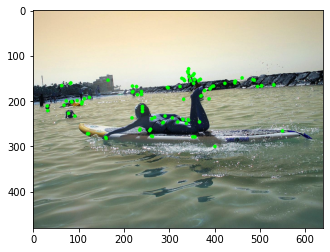

In [82]:
sample_coco_path = glob.glob(DATA_PATH + '/COCO/train2014/*')
img = sample_coco_path[7001]
img = cv.imread(img)
judge, resize_img, kp_list = detect_feature_points_with_resize(img, 1, 100) # [y,x,stregth]
# for k in kp_list:
#     print('y:%d, x:%d' % (int(k[0]),int(k[1])))
for y, x in kp_list:
    cv.circle(img, (int(x), int(y)), radius=4, color=(0,255,0), thickness=-1)
plt.imshow(img)
plt.show()

In [7]:
create_dataset_path = f'{DATA_PATH}/synthetic_shapes_ms-coco_akaze'
os.makedirs(create_dataset_path, exist_ok=True)
base_path = os.path.join(create_dataset_path, 'ms-coco')
os.makedirs(base_path, exist_ok=True)
for ip in ["images", "points"]:
    ip_path = os.path.join(base_path, ip)
    os.makedirs(ip_path, exist_ok=True)
    for data in ["training", "validation", "test"]:
        data_path = os.path.join(ip_path, data)
        os.makedirs(ip_path, exist_ok=True)

tasks = {'training':60000, 'validation':3000, 'test':1200}
for key, value in tasks.items():
    if key == 'training':
        coco_path = f'{DATA_PATH}/COCO/train2014/*'
    elif key == 'validation':
        coco_path = f'{DATA_PATH}/COCO/val2014/*'
    else:
        coco_path = f'{DATA_PATH}/COCO/test2014/*'
    save_img_path = os.path.join(base_path, 'images', key)
    save_pnt_path = os.path.join(base_path, 'points', key)
    coco_img_paths = natsort.natsorted(glob.glob(coco_path))
    randint_list = np.random.randint(0,len(coco_img_paths),(value))
    for num in randint_list:
        img_path = coco_img_paths[num]
        filename = os.path.basename(img_path)
        basename_without_ext = os.path.splitext(filename)[0]
        img = cv.imread(img_path)
        judge, resize_img, kp_list = detect_feature_points_with_resize(img, 1) # [y,x,stregth]
        if judge:
            cv.imwrite(f'{save_img_path}/{filename}', resize_img)
            np.save(f'{save_pnt_path}/{basename_without_ext}.npy', kp_list)